<a href="https://colab.research.google.com/github/INCREDIBLE-AURNOB/Human-Stress-Prediction-with-LSTM/blob/main/Human_Stress_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install opendatasets --quiet
!pip3 install efficientnet --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00


In [2]:
import opendatasets as od
dataset=od.download("https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alrafiaurnob
Your Kaggle Key: ··········


100%|██████████| 554k/554k [00:00<00:00, 44.4MB/s]

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [4]:
raw_df=pd.read_csv('/content/human-stress-prediction/Stress.csv')


In [5]:
raw_df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


<Axes: xlabel='label', ylabel='count'>

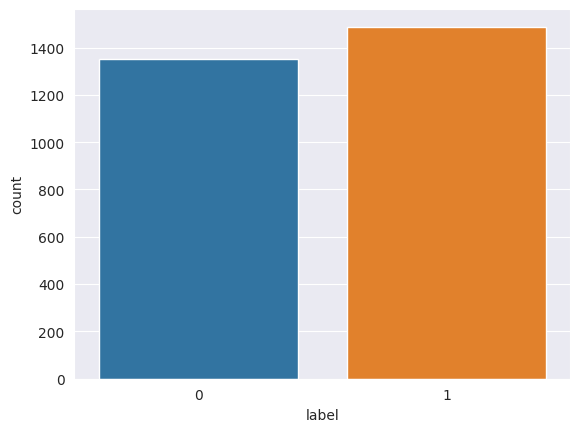

In [6]:
sns.set_style("darkgrid")
sns.countplot(data=raw_df,x=raw_df.label)

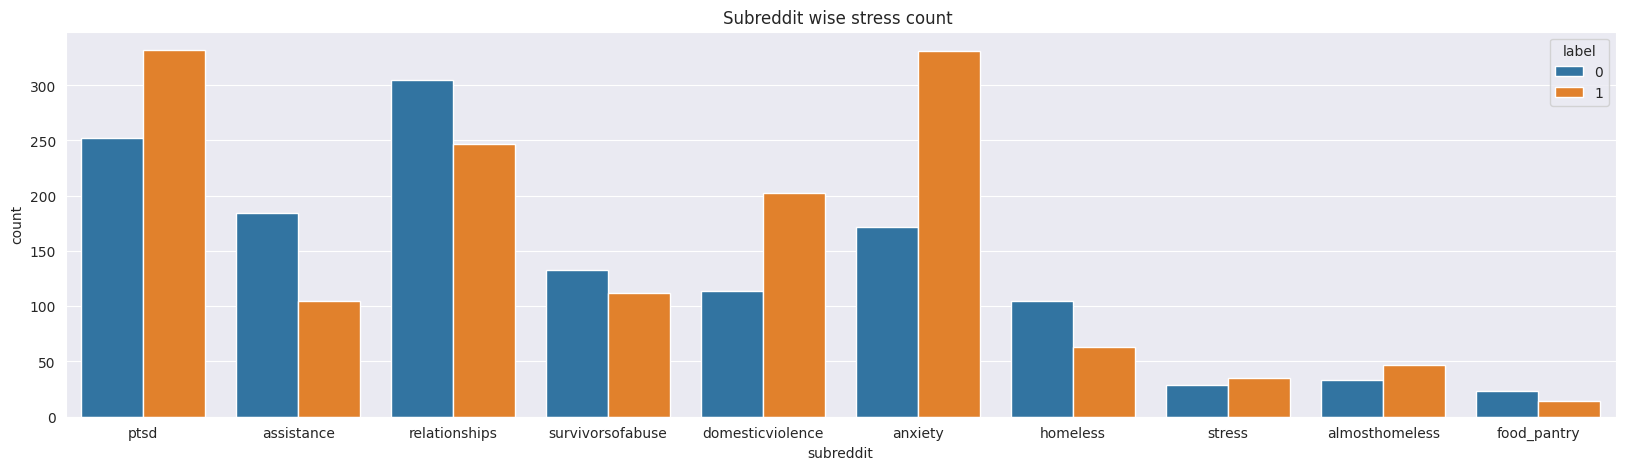

In [7]:
plt.figure(figsize=(20,5))
plt.title("Subreddit wise stress count ")
plt.xlabel("Subreddit")
sns.countplot(data=raw_df,x='subreddit',hue='label')
plt.show()

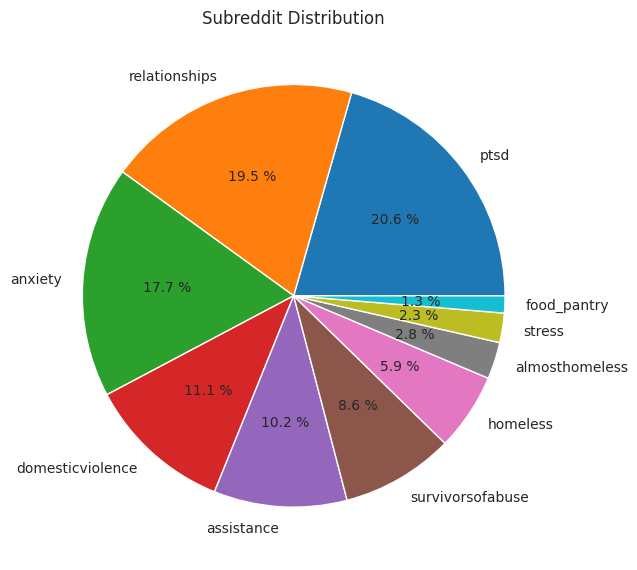

In [8]:
context=['subreddit']
plt.figure(figsize=(15,12))
for i in range(len(context)):
  plt.subplot(1,2,i+1)
  a=raw_df[context[i]].value_counts()
  title=a.index
  plt.title("Subreddit Distribution")
  plt.pie(x=a,labels=title,autopct="%.1f %%")
  plt.show()

In [9]:
raw_df.isna().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [10]:
raw_df.subreddit.value_counts()

ptsd                584
relationships       552
anxiety             503
domesticviolence    316
assistance          289
survivorsofabuse    245
homeless            168
almosthomeless       80
stress               64
food_pantry          37
Name: subreddit, dtype: int64

In [11]:
del raw_df['post_id']
del raw_df['sentence_range']

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
stop=set(stopwords.words('english'))
punctuation=list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Cleaning data

In [13]:
raw_df.head()

,subreddit,text,label,confidence,social_timestamp
0,ptsd,"He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,"Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,"until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [14]:
raw_df['text'].values

array(['He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI\'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f\'n worried about my heart. I do happen to have a physical in 48 hours.',
       "Hey there r/assistance, Not sure if this is the right place to post this.. but here goes =) I'm currently a student intern at Sandia National Labs and working on a survey to help improve our marketing outreach efforts at the many schools we recruit at around the country. We're looking for current undergrad/grad STEM students so if you're a STEM student or know STEM students, I would greatly appreciate if 

In [15]:
nlp=spacy.load('en_core_web_sm')

In [16]:
#defining function for preprocessing
def preprocess(text,remove_digits=True):
    if isinstance(text,str):
      text = re.sub('\W+',' ', text)                                        #for replacing non-word characters
      text = re.sub('\s+',' ', text)                                        #for replacng extra spaces
      text = re.sub("(?<!\w)\d+", "", text)                                 # Remove all numbers except those attached to a word
      text = re.sub("-(?!\w)|(?<!\w)-", "", text)                           # Remove all hyphens except between two words
      text=text.lower() if isinstance(text,str) else text
      nopunc=[char for char in text if char not in string.punctuation]      #for removing punctuation in the strings
      nopunc=''.join(nopunc)
      nopunc=' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])   #for removing stop words
      return nopunc
    else:
      return ''

# Defining a function for lemitization
def lemmatize(words):
   
    words=nlp(words)
    lemmas = []
    for word in words:
        
        lemmas.append(word.lemma_)
    return lemmas
#converting them into string
def listtostring(s):
    str1=' '
    return (str1.join(s))

def clean_text(input):
    word=preprocess(input)
    lemmas=lemmatize(word)
    return listtostring(lemmas)

In [17]:
#Apply function on review column
raw_df['text']=raw_df['text'].apply(clean_text)

In [18]:
raw_df['text'].values

array(['say feel way suggete go rest trigger ahead youi hypocondriac like decide look feeling doom hope maybe getting suck rabbit hole ludicrous conspiracy stupid psychic test new age b something could even laugh road end read sense doom indicative various health ailment one prone top doom gloom f n worried heart happen physical hour',
       'hey r assistance sure right place post go currently student intern sandia national labs work survey help improve marketing outreach effort many school recruit around country look current undergrad grad stem student stem student know stem student would greatly appreciate help take pass along short survey thank everyone help take survey enter drawing chance win one three amazon gcs',
       'mom hit newspaper shock would know like play hit smacking strike hit violence sort person send vibe ask universe yesterday decide take friend go help another friend move new place drive friend move strike shoulder address immediately th time tell thing friend d

In [19]:
raw_df.head()

,subreddit,text,label,confidence,social_timestamp
0,ptsd,say feel way suggete go rest trigger ahead you...,1,0.8,1521614353
1,assistance,hey r assistance sure right place post go curr...,0,1.0,1527009817
2,ptsd,mom hit newspaper shock would know like play h...,1,0.8,1535935605
3,relationships,meet new boyfriend amazing kind sweet good stu...,1,0.6,1516429555
4,survivorsofabuse,october domestic violence awareness month dome...,1,0.8,1539809005


## Worldcloud for real text (label 1)

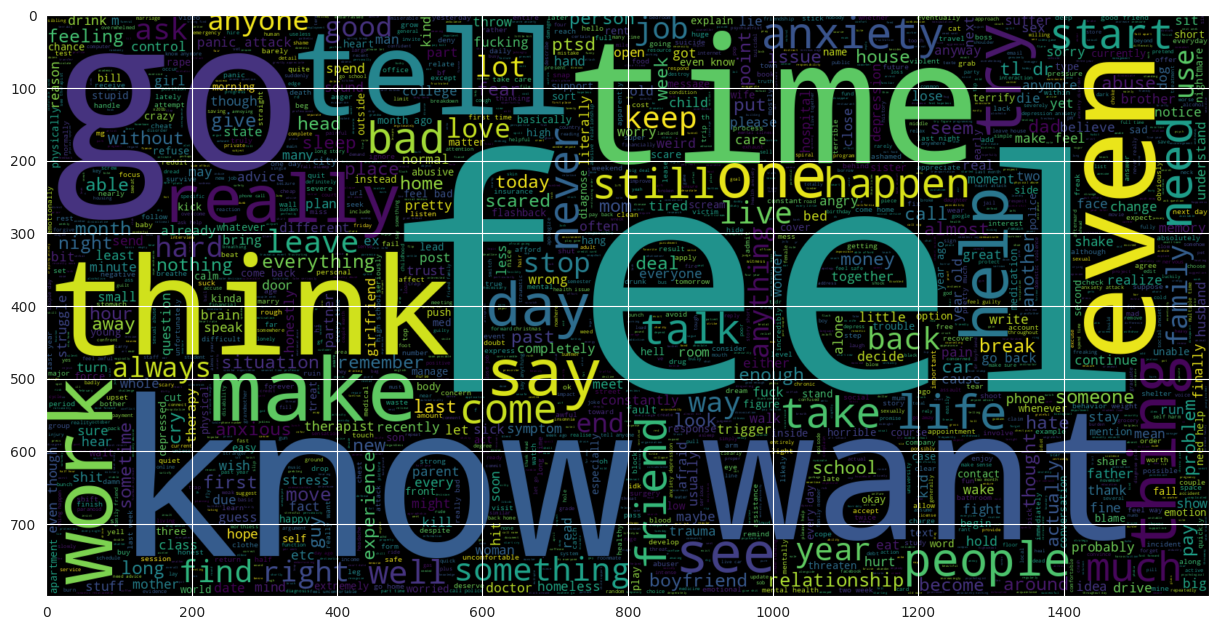

In [20]:
plt.figure(figsize = (15,15)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(raw_df[raw_df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

Worldcloud for real text (label 0)

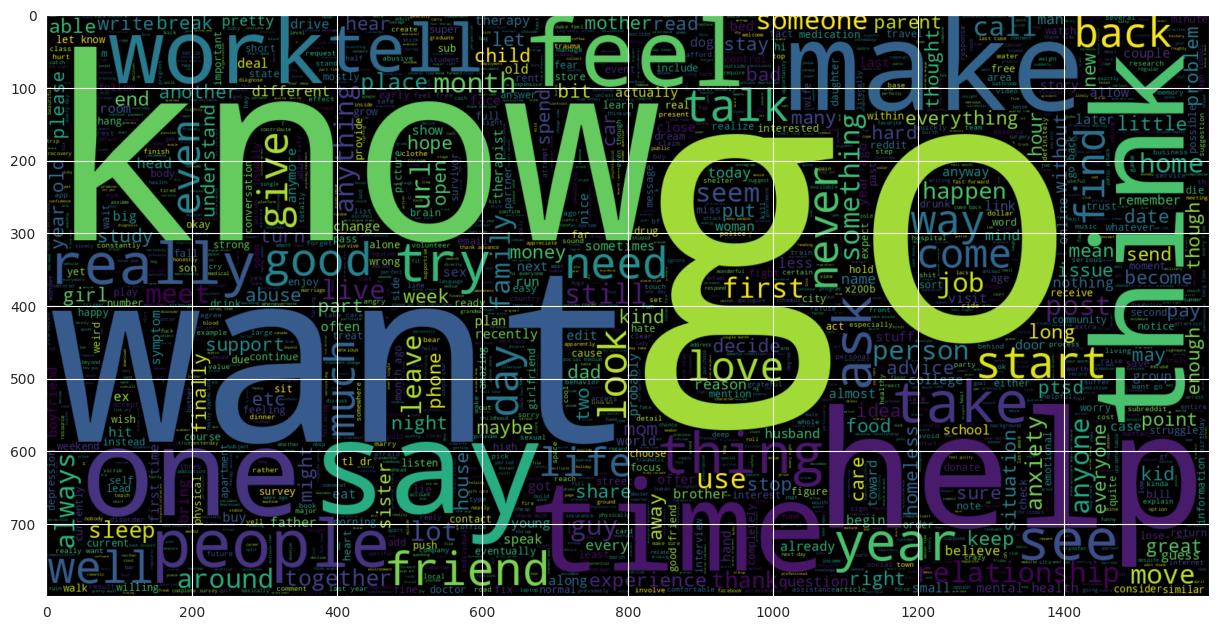

In [21]:
plt.figure(figsize = (15,15)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(raw_df[raw_df.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

## Number of words in text

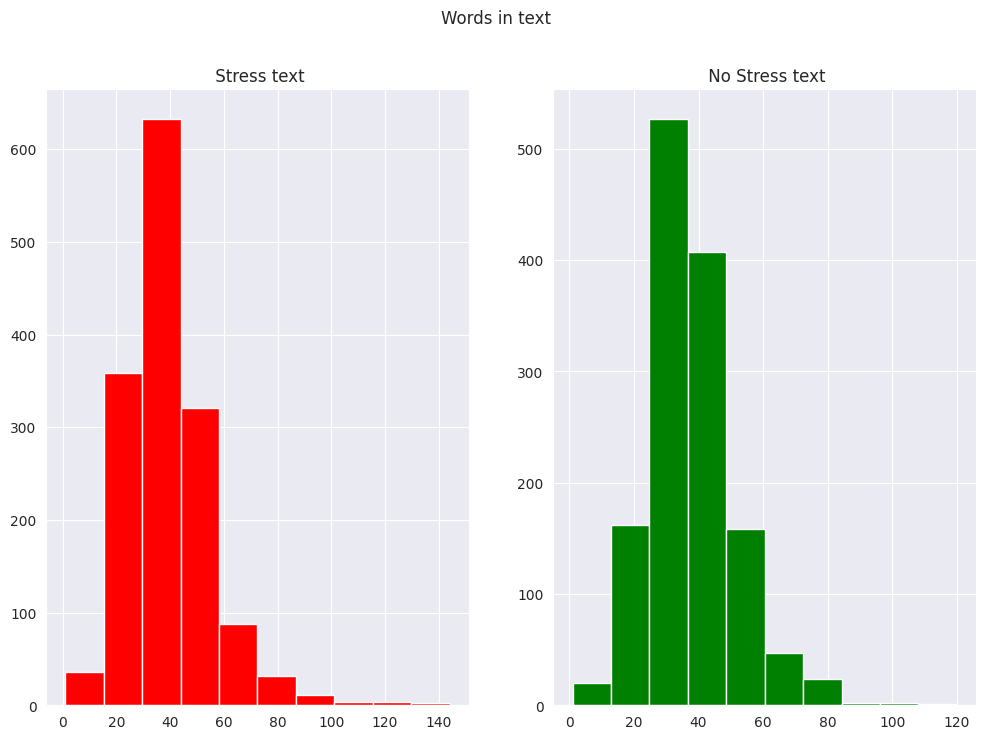

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=raw_df[raw_df['label']==1]['text'].str.split().map(lambda x:len(x))
ax1.hist(text_len,color='red')
text_len=raw_df[raw_df['label']==0]['text'].str.split().map(lambda x:len(x))
ax2.hist(text_len,color='green')
ax2.set_title(" No Stress text")
ax1.set_title(" Stress text")
fig.suptitle("Words in text")
plt.show()

In [23]:
def get_corpus(text):
  words=[]
  for i in text:
    for j in i.split():
      words.append(j.strip())
  return words
corpus=get_corpus(raw_df['text'])

In [24]:
corpus[:10]

['say',
 'feel',
 'way',
 'suggete',
 'go',
 'rest',
 'trigger',
 'ahead',
 'youi',
 'hypocondriac']

In [25]:
from collections import Counter
counter=Counter(corpus)
most_common=counter.most_common(20)
most_common=dict(most_common)

In [26]:
most_common

{'get': 1453,
 'go': 1278,
 'like': 1234,
 'feel': 1160,
 'know': 1062,
 'time': 942,
 'want': 833,
 'would': 761,
 'make': 748,
 'year': 712,
 'think': 686,
 'help': 678,
 'say': 653,
 'really': 651,
 'tell': 615,
 'work': 608,
 'even': 600,
 'one': 600,
 'thing': 565,
 'day': 550}

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus,n,g):
  vec=CountVectorizer(ngram_range=(g,g)).fit(corpus)
  bag_of_words=vec.transform(corpus)
  sum_words=bag_of_words.sum(axis=0)
  words_freq=[(word,sum_words[0,idx]) for word ,idx in vec.vocabulary_.items()]
  words_freq=sorted(words_freq,key=lambda x:x[1],reverse=True)
  return words_freq[:n]

## Unigram analysis

<Axes: >

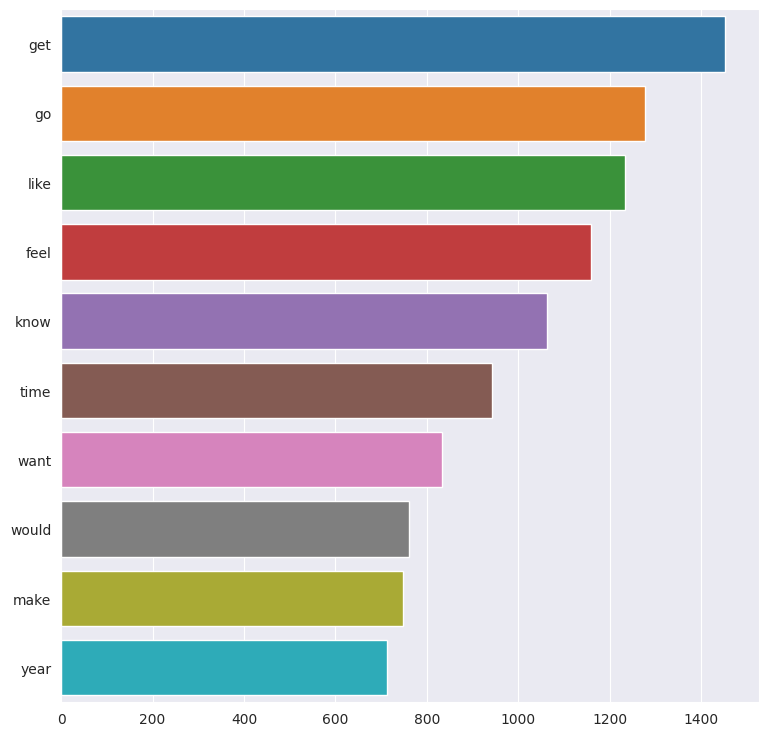

In [28]:
plt.figure(figsize=(9,9))
most_common_uni=get_top_text_ngrams(raw_df.text,10,1)
most_common_uni=dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=(list(most_common_uni.keys())))


Bigrams analysis

<Axes: >

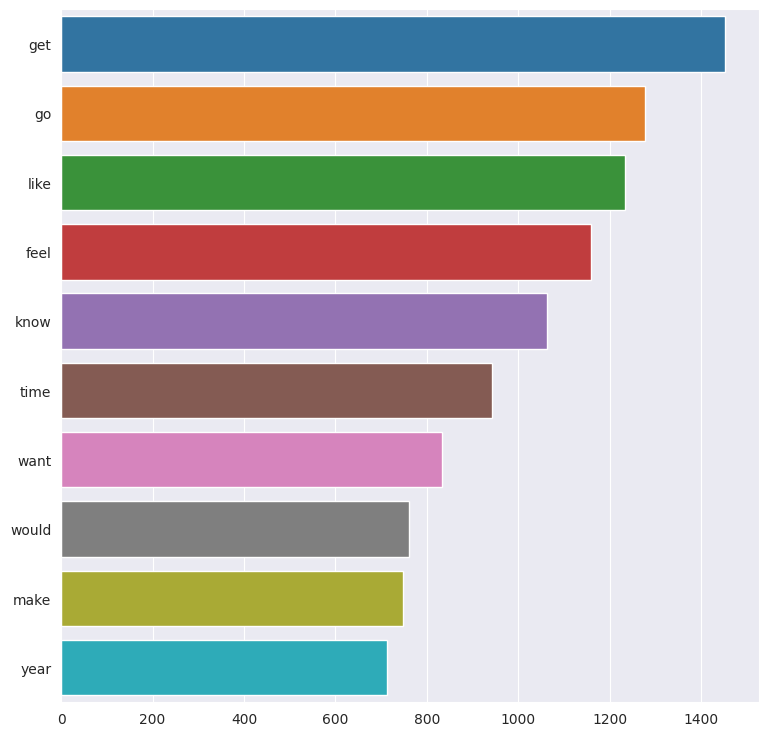

In [29]:
plt.figure(figsize=(9,9))
most_common_bi=get_top_text_ngrams(raw_df.text,10,2)
most_common_uni=dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

## Trigrams analysis

<Axes: >

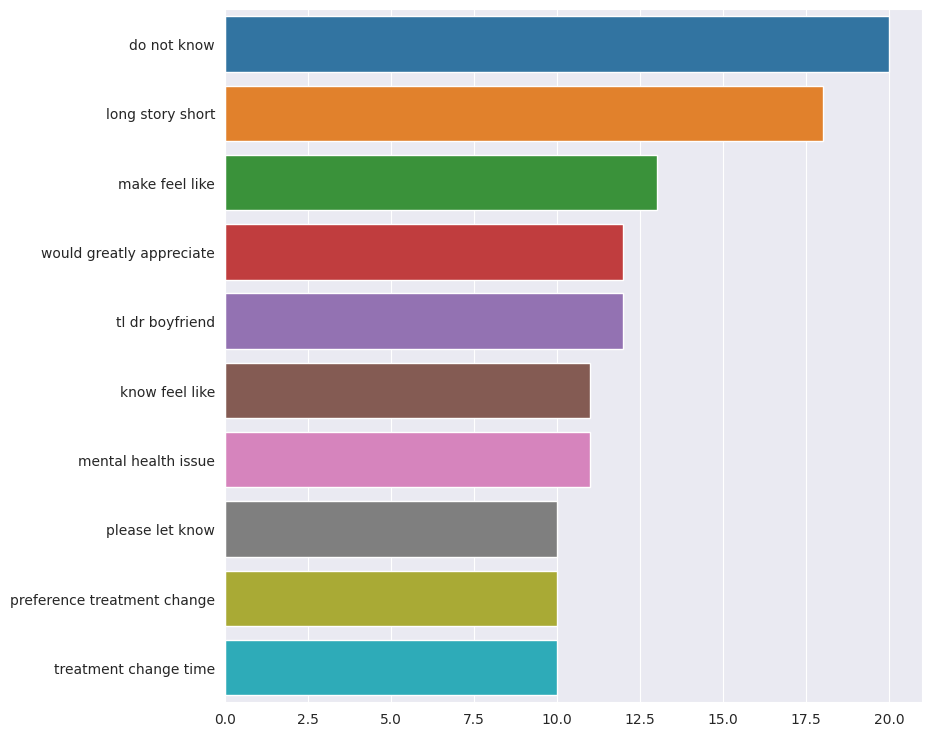

In [30]:

plt.figure(figsize=(9,9))
most_common_tri=get_top_text_ngrams(raw_df.text,10,3)
most_common_tri=dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

## Split into train and text data

In [31]:
x_train,x_test,y_train,y_test=train_test_split(raw_df.text,raw_df.label,test_size=0.2,random_state=42)

In [32]:
x_train.shape,y_train.shape

((2270,), (2270,))

In [33]:
x_test.shape,y_test.shape

((568,), (568,))

In [34]:
max_features=1000
maxlen=300

In [35]:
tokenizer=text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train=tokenizer.texts_to_sequences(x_train)
x_train=pad_sequences(tokenized_train,maxlen=maxlen)

In [36]:
type(x_train)

numpy.ndarray

In [37]:
x_test = [str(x) for x in x_test]

In [38]:
tokenized_test=tokenizer.texts_to_sequences(x_test)
x_test=pad_sequences(tokenized_test,maxlen=maxlen)

In [39]:
type(x_test)

numpy.ndarray

In [40]:
text_file=od.download('https://www.kaggle.com/datasets/icw123/glove-twitter?select=glove.twitter.27B.100d.txt')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alrafiaurnob
Your Kaggle Key: ··········


100%|██████████| 1.45G/1.45G [00:13<00:00, 114MB/s]


In [41]:
EMBEDDING_FILE='/content/glove-twitter/glove.twitter.27B.100d.txt'

In [42]:
def get_coefs(word,*arr):
  return word,np.asarray(arr,dtype='float32')
embeddings_index=dict(get_coefs(*o.rsplit(' ')) for o in open(EMBEDDING_FILE))

In [43]:
all_embs=np.stack(embeddings_index.values())
emb_mean,emb_std=all_embs.mean(),all_embs.std()
embed_size=all_embs.shape[1]

word_index=tokenizer.word_index
nb_words=min(max_features,len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [44]:
batch_size=256
epochs=10
embed_size=100

In [45]:
learning_rate=ReduceLROnPlateau(monitor='val_accuracy',
                                patirnce=2,verbose=1,factor=-.5,min_lr=0.00001)

## Train model

In [46]:
model=Sequential()
model.add(Embedding(max_features,output_dim=embed_size,weights=[embedding_matrix],
                    input_length=maxlen,trainable=False))
#LSTM
model.add(LSTM(units=128,return_sequences=True,recurrent_dropout=0.25,dropout=0.25))
model.add(LSTM(units=64,recurrent_dropout=0.1,dropout=0.1))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          100000    
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 268,769
Trainable params: 168,769
Non-trainable params: 100,000
_________________________________________________________________


In [48]:
history=model.fit(x_train,y_train,batch_size=batch_size,
                  validation_data=(x_test,y_test),epochs=epochs,
                  callbacks=[learning_rate])

Epoch 1/10
9/9 [==============================] - 61s 6s/step - loss: 0.7304 - accuracy: 0.5075 - val_loss: 0.6889 - val_accuracy: 0.5581 - lr: 0.0100
Epoch 2/10
9/9 [==============================] - 53s 6s/step - loss: 0.6826 - accuracy: 0.5449 - val_loss: 0.6610 - val_accuracy: 0.6232 - lr: 0.0100
Epoch 3/10
9/9 [==============================] - 72s 8s/step - loss: 0.6424 - accuracy: 0.6507 - val_loss: 0.6727 - val_accuracy: 0.6144 - lr: 0.0100
Epoch 4/10
9/9 [==============================] - 55s 6s/step - loss: 0.6216 - accuracy: 0.6392 - val_loss: 0.6111 - val_accuracy: 0.6778 - lr: 0.0100
Epoch 5/10
9/9 [==============================] - 56s 6s/step - loss: 0.5896 - accuracy: 0.6956 - val_loss: 0.5843 - val_accuracy: 0.7025 - lr: 0.0100
Epoch 6/10
9/9 [==============================] - 53s 6s/step - loss: 0.5608 - accuracy: 0.7110 - val_loss: 0.5646 - val_accuracy: 0.7007 - lr: 0.0100
Epoch 7/10
9/9 [==============================] - 55s 6s/step - loss: 0.5396 - accuracy: 0.719

## Analysis the model

In [49]:
print(" Accuracy on Training data: ",model.evaluate(x_train,y_train)[1] *100 ,"%")
print(" Accuracy on Test data: ",model.evaluate(x_test,y_test)[1] *100 ,"%")

71/71 [==============================] - 13s 190ms/step - loss: 0.4574 - accuracy: 0.7683
 Accuracy on Training data:  76.82819366455078 %
18/18 [==============================] - 3s 168ms/step - loss: 0.5874 - accuracy: 0.6901
 Accuracy on Test data:  69.01408433914185 %


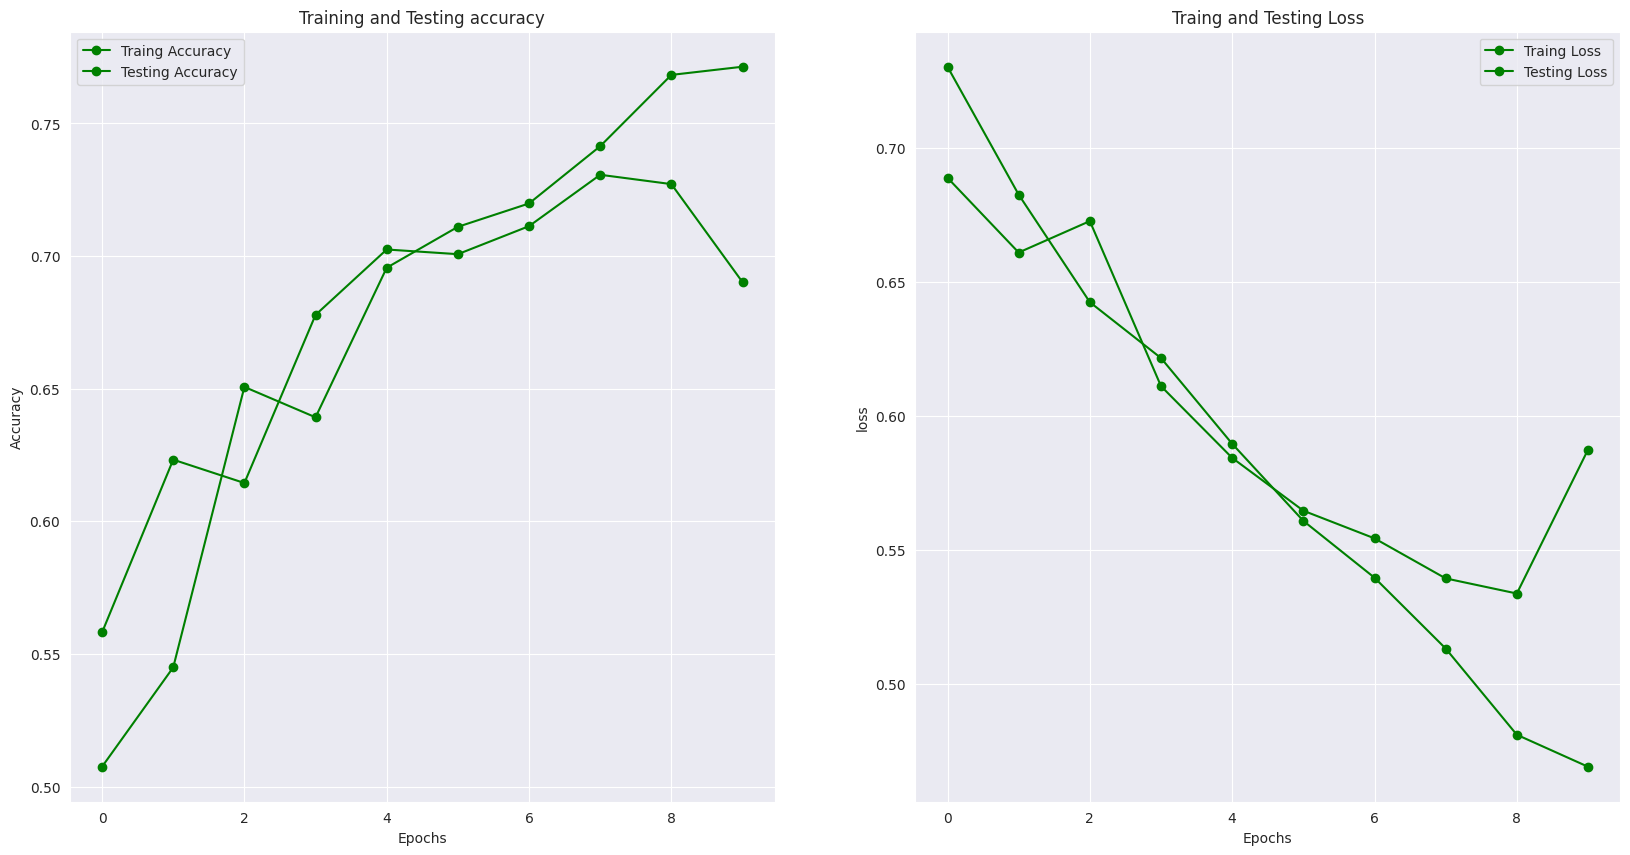

In [50]:
epochs=[i for i in range(10)]
fig,ax=plt.subplots(1,2)
train_acc=history.history['accuracy']
train_loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs,train_acc,'go-',label="Traing Accuracy")
ax[0].plot(epochs,val_acc,'go-',label="Testing Accuracy")
ax[0].set_title('Training and Testing accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs,train_loss,'go-',label="Traing Loss")
ax[1].plot(epochs,val_loss,'go-',label="Testing Loss")
ax[1].set_title("Traing and Testing Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")
plt.show()

In [51]:
pred = model.predict(x_test) 
pred[:5]

18/18 [==============================] - 4s 192ms/step


array([[0.27854046],
       [0.3294742 ],
       [0.69973755],
       [0.54791385],
       [0.13194755]], dtype=float32)